Metody rozpoznawania obrazów - zadanie 1

**Piotr Zawiślan**

_**Bliskie spotkania trzeciego stopnia z Pytorch'em**_

Pozornie celem zadania jest zaznajomienie się z prostym klasyfikatorem binarnym jakim jest
regresja logistyczna. Tak naprawdę jednak jest to pretekst, by zacząć się oswajać z wybranym
przez siebie frameworkiem wspomagającym obliczenia tensorowe (najlepiej gdyby wspierał też
out-of-the-box uczenie maszynowe - i.e. zawierał gotowe implementacje funkcji, o których mówimy
na zajęciach).

\[UWAGA: w ramach tego ćwiczenia NIE korzystamy z gotowej pełnej implementacji regresji
logistycznej - naszym zadaniem jest poskładanie jej samodzielnie z nieco drobniejszych klocków.\]

# Realizacja zadania

In [1]:
import numpy as np
import torch
import os

In [2]:
torch.cuda.is_available()

True

In [3]:
np.random.seed(311)

PLOTS_PATH = os.path.join(".", "plots")
os.makedirs(PLOTS_PATH, exist_ok=True)

In [4]:
def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = os.path.join(PLOTS_PATH, fig_id + "." + fig_extension)
    print("Saving figure", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)

## Ciuchy z Zalando

Do realizacji zadania potrzebny nam będzie odpowiednio przygotowany zbiór danych. Zaczniemy
od czegoś prostego: skorzystamy ze zbioru Fashion-MNIST zawierającego wycentrowane zdjęcia
różnych typów ubrań, zebrane na portalu Zalando. Zbiór jest dostępny na portalu GitHub: https://
github.com/zalandoresearch/fashion-mnist (w praktyce większość wymienionych w poprzedniej
sekcji bibliotek zawiera dedykowane wsparcie do jego pobierania - bo to bardzo popularny
startowy problem do wszelkich eksperymentów).

W przypadku tego zadania będziemy musieli dostosować pierwotny stan zbioru do naszych
potrzeb.

---

1.  Po pierwsze - potrzebujemy ograniczyć go tylko do dwóch klas. Najlepiej mocno różniących się - ułatwi nam to wizualizację wyników. Prowadzący poleca wybrać sukienki (klasa numer 3) i sandały (klasa numer 5)

---

2. Prawdopodobnie wczytaliśmy nasz zbiór do czterech struktur - po dwóch na zbiór treningowy i testowy. Dwie z nich to tensory trójwymiarowe o wymiarach (60000, 28, 28) i (10000, 28, 28) - zawierające poszczególne zdjęcia. Pozostałe dwa to tensory jednowymiarowe (wektory) z informacją o tym, do jakiej klasy należą.

---

3. Potrzebujemy odfiltrować elementy należące do interesujących nas klas (w efekcie
zmniejszając zbiory 5 razy)

    -  By to zrobić, możemy zacząć od przygotowania nowych wektorów, zawierających binarną maskę z oznaczonymi elementami do zachowania.
    - Taką maskę trzeba następnie zaaplikować, wycinając to co nas interesuje.

---

4. Wykonaj selekcję właściwych zdjęć.
    - *Napisz w raporcie informację o tym, jakich funkcji użyłaś/eś do tego celu.*
    - Sprawdź, czy na pewno się udała - podejrzyj zawartość kilku zdjęć ze skurczonego zbioru.

In [5]:
from torchvision import datasets
from torchvision.transforms import ToTensor

# Download training data
fm_train_data = datasets.FashionMNIST(
    root="data",
    train=True,
    download=True,
    transform=ToTensor(),
)

# Download test data
fm_test_data = datasets.FashionMNIST(
    root="data",
    train=False,
    download=True,
    transform=ToTensor(),
)

Saving figure full_dataset_samples


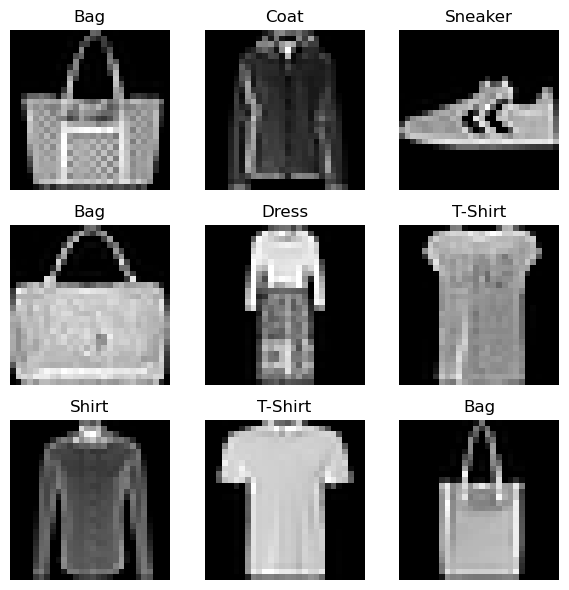

In [6]:
import matplotlib.pyplot as plt

labels_map = {
    0: "T-Shirt",
    1: "Trouser",
    2: "Pullover",
    3: "Dress",
    4: "Coat",
    5: "Sandal",
    6: "Shirt",
    7: "Sneaker",
    8: "Bag",
    9: "Ankle Boot",
}

figure = plt.figure(figsize=(6, 6))
cols, rows = 3, 3
for i in range(1, cols * rows + 1):
    sample_idx = torch.randint(len(fm_train_data), size=(1,)).item()
    img, label = fm_train_data[sample_idx]
    figure.add_subplot(rows, cols, i)
    plt.title(labels_map[label])
    plt.axis("off")
    plt.imshow(img.squeeze(), cmap="gray")
save_fig('full_dataset_samples')
plt.show()

In [7]:
fm_train_X = fm_train_data.data
fm_test_X = fm_test_data.data

In [8]:
fm_train_X.shape

torch.Size([60000, 28, 28])

In [9]:
fm_test_X.shape

torch.Size([10000, 28, 28])

In [10]:
fm_train_y = fm_train_data.targets
fm_test_y = fm_test_data.targets

In [11]:
fm_train_y.shape

torch.Size([60000])

In [12]:
fm_test_y.shape

torch.Size([10000])

Ogarniczenie do 2 klas

In [13]:
fm_train_X_trimmed = fm_train_X[(fm_train_y == 3) | (fm_train_y == 5)]
fm_train_y_trimmed = fm_train_y[(fm_train_y == 3) | (fm_train_y == 5)]

In [14]:
fm_test_X_trimmed = fm_test_X[(fm_test_y == 3) | (fm_test_y == 5)]
fm_test_y_trimmed = fm_test_y[(fm_test_y == 3) | (fm_test_y == 5)]

In [15]:
fm_train_X_trimmed = fm_train_X_trimmed.numpy()
fm_train_y_trimmed = fm_train_y_trimmed.numpy()
fm_test_X_trimmed = fm_test_X_trimmed.numpy()
fm_test_y_trimmed = fm_test_y_trimmed.numpy()

In [16]:
fm_train_X_trimmed.shape

(12000, 28, 28)

- `sukienka`: `3` >>> `0`
- `sandał`: `5` >>> `1`

In [17]:
fm_train_y_trimmed[fm_train_y_trimmed==3] = 0  # sukienki
fm_train_y_trimmed[fm_train_y_trimmed==5] = 1  # sandały

In [18]:
fm_test_y_trimmed[fm_test_y_trimmed==3] = 0  # sukienki
fm_test_y_trimmed[fm_test_y_trimmed==5] = 1  # sandały

Saving figure trimmed_dataset_samples


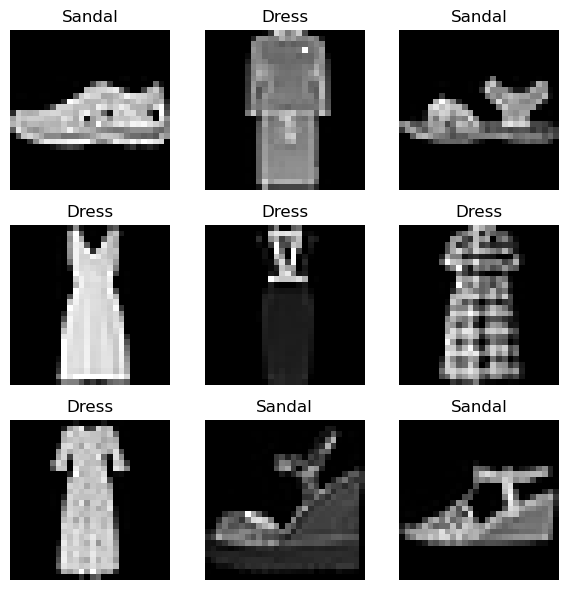

In [19]:
import matplotlib.pyplot as plt

labels_map_trimmed = {
    0: "Dress",
    1: "Sandal"
}

figure = plt.figure(figsize=(6, 6))
cols, rows = 3, 3
for i in range(1, cols * rows + 1):
    sample_idx = torch.randint(len(fm_train_y_trimmed), size=(1,)).item()
    img, label = fm_train_X_trimmed[sample_idx, ...], fm_train_y_trimmed[sample_idx].item()
    figure.add_subplot(rows, cols, i)
    plt.title(labels_map_trimmed[label])
    plt.axis("off")
    plt.imshow(img.squeeze(), cmap="gray")
    
save_fig('trimmed_dataset_samples')
plt.show()

Custom "im-memory" Dataset class

In [20]:
from torch.utils.data import Dataset

class FashionMNISTTrimmedDataset(Dataset):
    def __init__(self, X: np.ndarray, y: np.ndarray, transform=None, target_transform=None):
        self.X = X
        self.y = torch.from_numpy(y)
        self.transform = transform
        self.target_transform = target_transform
        self.classes = [0, 1]
    
    def __len__(self):
        return len(self.y)
    
    def __getitem__(self, idx):
        image = self.X[idx]
        label = self.y[idx]
        if self.transform:
            image = self.transform(image)
        if self.target_transform:
            label = self.target_transform(label)
        return image, label

In [21]:
fm_train_dataset = FashionMNISTTrimmedDataset(X=fm_train_X_trimmed, 
                                              y=fm_train_y_trimmed, 
                                              transform=ToTensor())

fm_test_dataset = FashionMNISTTrimmedDataset(X=fm_test_X_trimmed, 
                                             y=fm_test_y_trimmed,
                                             transform=ToTensor())

Check compatibility with DataLoader

In [22]:
from torch.utils.data import DataLoader

fm_train_dataloader = DataLoader(fm_train_dataset, batch_size=32, shuffle=True)
fm_test_dataloader = DataLoader(fm_test_dataset, batch_size=32, shuffle=True)

Feature batch shape: torch.Size([32, 1, 28, 28])
Labels batch shape: torch.Size([32])


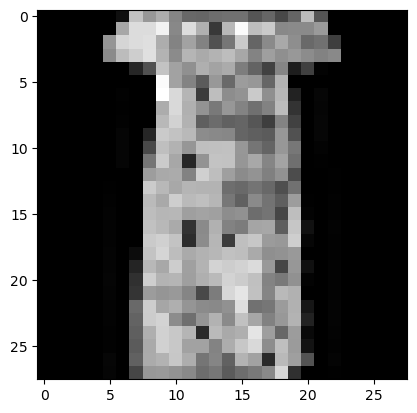

Label: 0


In [23]:
# Display image and label.
train_features, train_labels = next(iter(fm_train_dataloader))
print(f"Feature batch shape: {train_features.size()}")
print(f"Labels batch shape: {train_labels.size()}")
img = train_features[0].squeeze()
label = train_labels[0]
plt.imshow(img, cmap="gray")
plt.show()
print(f"Label: {label}")

## Model decyzyjny - regresja logistyczna

Teraz zajmiemy się implementacją samego modelu. Wiele bibliotek oferuje dedykowane
mechanizmy do określania, że coś jest modelem - wymagając podania jakie jest wejście, wyjście, z
czego się składa, jak będą dobierane i oceniane jego parametry.

---

*Jak rozwiązano sprawę konstrukcji modeli w wybranym przez ciebie frameworku? Napisz o
tym (bardzo krótko i ogólnikowo) w raporcie.*

### Wstępna obróbka i skrawanie

Musimy zacząć od dostosowania naszych wejściowych fotografii do formatu, na którym
dobrze pracuje regresja logistyczna (wektorów liczbowych o małym rozrzucie wartości). W
tym celu wykonujemy poniższe kroki.

---

1. Najpierw zamieniamy obrazy (macierze) ze zbioru danych na wektory [biblioteka powinna oferować funkcję "spłaszczającą"].

---

2. Potem normalizujemy wartości w poszczególnych wektorach, tak by zawierały się w zakresie od 0 do 1 [ponownie - powinna istnieć gotowa funkcja normalizująca/skalująca].

---

3. Na koniec należy zamienić etykiety klas na 1 (klasa A) i 0 (klasa B) - tak by można je traktować jak prawdopodobieństwo.

---

4. *Napisz w raporcie jakich funkcji użyłeś i co robią z danymi. Pamiętaj, że powinny być częścią struktury modelu (i obsłużyć też nowe obserwacje przychodzące w przyszłości).*

---

5. *Na tym etapie warto sprawdzić, że to co robimy rzeczywiście działa. Czy biblioteka, której używasz wspiera debugowanie "na żywo"? Napisz o tym w raporcie.*

### Tu podejmowane są decyzje

Kontynuujmy potok przetwarzania w modelu decyzyjnym, implementując samą regresję logistyczną.

---

1. Na początek potrzebujemy funkcji liniowej działającej na wejściowych wektorach.

    - Najłatwiejszy sposób na jej zrealizowanie to wykorzystanie mechanizmu, który implementuje gęsto połączoną (dense) warstwę sieci neuronowej o jednym wyjściu [znów - powinien nam tu pomóc framework]. Dokładne wyjaśnienie dlaczego pojawi się na kolejnych zajęciach.
    
---

2. Potem potrzebujemy przetworzyć uzyskane wyniki na prawdopodobieństwo.

    - Tutaj pomoże funkcja logistyczna (logistic function), znana też jako sigmoida (sigmoid). Takie dalsze przetwarzanie wyniku funkcji liniowej jest często nazywane aktywacją (activation) [i prawdopodobnie pod taką nazwą trzeba szukać go w wybranej bibliotece].

---

3. Zaimplementuj całość, sprawdź czy uzyskiwane wyniki mają sens (od strony matematycznej).

---

Wagi funkcji liniowej (te zawarte w gęstej warstwie) można potraktować jako formę "filtra" albo "soczewki" spoglądającej na wejściową fotografię - jest ich przecież dokładnie 28*28.

1. Dowiedz się, jak dobrać się do nich w swojej bibliotece.

2. Pobierz ich startowe wartości.

3. Zamień wektor wartości na macierz o rozmiarze (28, 28) - proces odwrotny do tego, który był stosowany przy zamianie fotografii na wektor.

4. Wyplotuj taki obraz - co widzisz? Prawdopodobnie losowy bezsensowny szum. ;]

In [24]:
from torch import nn


# Get cpu or gpu device for training.
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using {device} device")


# Define model
class LogRegNN(nn.Module):
    def __init__(self, in_features=28*28, out_features=1):
        super(LogRegNN, self).__init__()
        self.stack = nn.Sequential(
            nn.Flatten(),
            nn.Linear(in_features, out_features),
            nn.Sigmoid()
        )

    def forward(self, x):
        probs = self.stack(x)
        return probs


model = LogRegNN().to(device)
print(model)

Using cuda device
LogRegNN(
  (stack): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=784, out_features=1, bias=True)
    (2): Sigmoid()
  )
)


In [25]:
len(fm_train_dataset.classes)

2

In [26]:
def plot_model_0_layer_weights_as_img(model: LogRegNN, save=False, title="lmao"):
    g = model.parameters()
    weights = next(g)
    weights = weights.reshape((28, 28))
    plt.imshow(weights.cpu().detach().numpy(), cmap="gray")
    plt.axis('off')
    if save:
        save_fig(title)
    plt.show()

Saving figure initial_weights


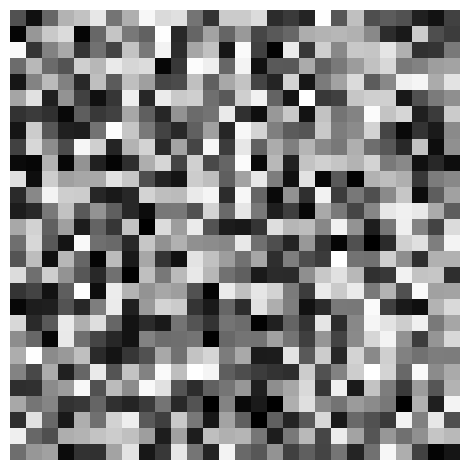

In [27]:
plot_model_0_layer_weights_as_img(model=model, save=True, title='initial_weights')

### Pora na edukację

Pozostaje tylko dopasować nasz model do rzeczywistości (danych treninowych).

---

1. W tym celu skorzystamy z mechanizmu dopasowywania (fit) modelu do danych [powinna wspierać go biblioteka].
    - Potrzebny jest nam sposób oceny jak "dobre" jest dopasowanie - skorzystamy z binarnej entropii krzyżowej (binary cross entropy) [powinna istnieć gotowa implementacja]. O tym co to właściwie jest było już trochę na PSI - temat ma też szansę wrócić na kolejnych zajęciach.
    - Potrzebujemy też mechanizmu, który znajdzie takie parametry, dla których jest dopasowanie będzie ocenione "najlepiej" - tu użyjemy stochastycznego spadku po gradiencie (stochastic gradient descent) - jak wyżej, było o nim na PSI, może jeszcze wróci jako temat [implementację powinna oferować biblioteka].
    
---

2. Zaimplementuj taki sposób strojenia modelu.
    - Napisz w raporcie jakich elementów biblioteki użyłeś.
    
---

3. Uruchom strojenie na danych treningowych i poczekaj, aż się skończy. Najlepiej wykonaj kilka-kilkanaście iteracji po wszystkich obserwacjach: tzw. epok (epochs).

---

4. Jak teraz wygląda "filtr" uzyskany z wag modelu (ten sam, który podglądaliśmy w punkcie 6.)? Czy ma jakiś sens, biorąc pod uwagę co chcieliśmy rozpoznawać?

---

5. Czy nasz model podejmuje właściwą decyzję (odróżnia sukienki od sandałów) w przypadku danych treningowych? Sprawdź na kilku przykładach.

In [28]:
# binary cross entropy + SGD

cross_entropy_loss = nn.BCELoss()  # .to(device)
optimizer = torch.optim.SGD(model.parameters(), lr=1e-3)

In [29]:
def train(dataloader, model, loss_fn, optimizer):
    size = len(dataloader.dataset)
    device = "cuda" if torch.cuda.is_available() else "cpu"
    for batch, (X, y) in enumerate(dataloader):
        X, y = X.float().to(device), y.float().to(device)
        prediction = model(X)
        loss = loss_fn(prediction, y.view(-1, 1))
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
#         if batch % 100 == 0:
#             loss, current = loss.item(), batch * len(X)
#             print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")

In [30]:
def test(dataloader, model, loss_fn):
    size = len(dataloader.dataset)
    device = "cuda" if torch.cuda.is_available() else "cpu"
    num_batches = len(dataloader)
    test_loss, correct = 0, 0
    tp, fp, tn, fn = 0, 0, 0, 0
    
    with torch.no_grad():
        for X, y in dataloader:
            X, y = X.float().to(device), y.float().to(device)
            prediction = model(X)
            test_loss += loss_fn(prediction, y.view(-1, 1)).item()
            
            y_np = y.cpu().numpy().reshape(-1, 1).astype(np.int32)
            preds = prediction.cpu().numpy()
            preds[preds < 0.5] = 0
            preds[preds >= 0.5] = 1
            preds = preds.astype(np.int32)
            
            correct += (preds == y_np).astype(np.float32).sum().item()
            tp += ((preds == y_np) & (preds == 1)).astype(np.float32).sum()
            fp += ((preds != y_np) & (preds == 1)).astype(np.float32).sum()
            tn += ((preds == y_np) & (preds == 0)).astype(np.float32).sum()
            fn += ((preds != y_np) & (preds == 0)).astype(np.float32).sum()

    test_loss /= num_batches
    correct /= size
    precision = tp / (tp + fp)
    recall = tp / (tp + fn)
    print((f"Test Error: \naccuracy: {(100*correct):>0.01f}%, precision: {(100*precision):>0.01f}%,"
          f" recall: {(100*recall):>0.01f}%, avg loss: {test_loss:>8f} \n"))

In [31]:
epochs = 20
for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    train(fm_train_dataloader, model, cross_entropy_loss, optimizer)
    test(fm_test_dataloader, model, cross_entropy_loss)
print("Done!")

Epoch 1
-------------------------------
Test Error: 
accuracy: 99.3%, precision: 99.6%, recall: 99.0%, avg loss: 0.258491 

Epoch 2
-------------------------------
Test Error: 
accuracy: 99.3%, precision: 99.4%, recall: 99.2%, avg loss: 0.172242 

Epoch 3
-------------------------------
Test Error: 
accuracy: 99.2%, precision: 99.3%, recall: 99.2%, avg loss: 0.133608 

Epoch 4
-------------------------------
Test Error: 
accuracy: 99.2%, precision: 99.2%, recall: 99.2%, avg loss: 0.110480 

Epoch 5
-------------------------------
Test Error: 
accuracy: 99.2%, precision: 99.2%, recall: 99.2%, avg loss: 0.096045 

Epoch 6
-------------------------------
Test Error: 
accuracy: 99.2%, precision: 99.2%, recall: 99.3%, avg loss: 0.085752 

Epoch 7
-------------------------------
Test Error: 
accuracy: 99.4%, precision: 99.2%, recall: 99.5%, avg loss: 0.077870 

Epoch 8
-------------------------------
Test Error: 
accuracy: 99.4%, precision: 99.2%, recall: 99.5%, avg loss: 0.071590 

Epoch 9


In [32]:
classes = {
    0: 'sandal',
    1: 'dress'
}

model.eval()
X, y = next(iter(fm_test_dataloader))
x_item, y_item = X[0], y[0]
for x_item, y_item in list(zip(X, y))[:10]:
    with torch.no_grad():
        pred = model.to('cpu')(x_item)
        predicted, actual = classes[0 if pred < 0.5 else 1], classes[int(y_item)]
        print(f'Predicted: "{predicted}", Actual: "{actual}"')

Predicted: "dress", Actual: "dress"
Predicted: "dress", Actual: "dress"
Predicted: "dress", Actual: "dress"
Predicted: "sandal", Actual: "sandal"
Predicted: "dress", Actual: "dress"
Predicted: "dress", Actual: "dress"
Predicted: "sandal", Actual: "sandal"
Predicted: "sandal", Actual: "sandal"
Predicted: "sandal", Actual: "sandal"
Predicted: "sandal", Actual: "sandal"


Saving figure after_training_weights


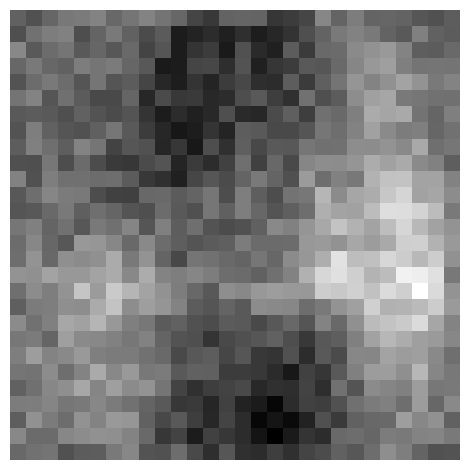

In [33]:
plot_model_0_layer_weights_as_img(model=model, save=True, title='after_training_weights')

Zrobione, co teraz, jak żyć?

W ramach zaliczenia zadania wrzuć dwa pliki:

- PDF z raportem zawierającym wspomniane w tekście informacje.
- ZIP zawierający kod, który realizuje wszystkie powyższe zadania.

PS. Nie panikuj (choć biblioteka może na początku przytłoczyć). W razie problemów - pytaj
prowadzącego!

Dobrej zabawy i powodzenia!